##Upload the CSV file in Google Colab

In [1]:
from google.colab import files
uploaded = files.upload()



Saving Gold.csv to Gold (2).csv


##Load and preprocess the gold dataset

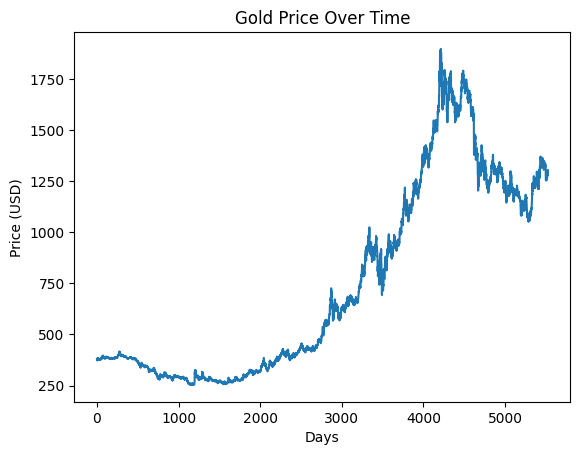

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assumes the uploaded file is named 'Gold.csv'
df = pd.read_csv("Gold.csv")
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values("DATE")

# Use only the 'VALUE' column
gold_prices = df['VALUE'].values.reshape(-1, 1)

# Normalize the values
scaler = MinMaxScaler()
gold_prices_scaled = scaler.fit_transform(gold_prices)

# Convert to float_data array like in the notebook
float_data = gold_prices_scaled.astype('float32')

# Plot raw gold prices
plt.plot(gold_prices)
plt.title("Gold Price Over Time")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.show()

##Generator Function

In [3]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][0]
        yield samples, targets

##Define parameters and splits

In [4]:
lookback = 30     # past 30 days
step = 1
delay = 1         # next day prediction
batch_size = 32

# Define train/val/test indices
num_data = len(float_data)
train_index = 0
val_index = int(num_data * 0.7)
test_index = int(num_data * 0.9)

train_gen = generator(float_data, lookback, delay, train_index, val_index,
                      shuffle=True, step=step, batch_size=batch_size)

val_gen = generator(float_data, lookback, delay, val_index, test_index,
                    step=step, batch_size=batch_size)

test_gen = generator(float_data, lookback, delay, test_index, None,
                     step=step, batch_size=batch_size)

val_steps = (test_index - val_index - lookback) // batch_size
test_steps = (len(float_data) - test_index - lookback) // batch_size

##Build GRU model

In [5]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop', loss='mae')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


##rain the model

In [6]:
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0224 - val_loss: 0.0128
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0066 - val_loss: 0.0165
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0061 - val_loss: 0.0130
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0058 - val_loss: 0.0107
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0057 - val_loss: 0.0108
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0053 - val_loss: 0.0124
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0051 - val_loss: 0.0115
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0051 - val_loss: 0.0132
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0050 - val_loss: 0.0102
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0050 - val_loss: 0.0118
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0049 - val_loss: 0.0118
Epoch 12/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/st

##Plot training and validation loss

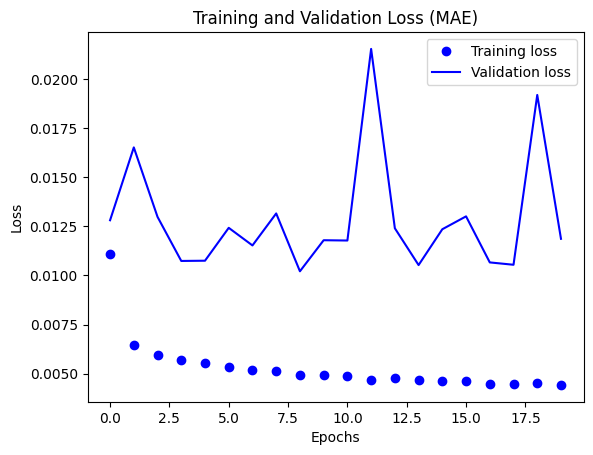

In [7]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss (MAE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##Evaluate model on test data

In [8]:
test_samples = []
test_targets = []

for _ in range(test_steps):
    sample_batch, target_batch = next(test_gen)
    predictions = model.predict(sample_batch)
    test_samples.extend(predictions.flatten())
    test_targets.extend(target_batch)

# Inverse transform to original scale
test_samples_inv = scaler.inverse_transform(np.array(test_samples).reshape(-1, 1)).flatten()
test_targets_inv = scaler.inverse_transform(np.array(test_targets).reshape(-1, 1)).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


##Accuracy metrics

In [9]:
mae = mean_absolute_error(test_targets_inv, test_samples_inv)
mse = mean_squared_error(test_targets_inv, test_samples_inv)
rmse = np.sqrt(mse)
r2 = r2_score(test_targets_inv, test_samples_inv)

print(f"\n📊 Evaluation Metrics:")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")



📊 Evaluation Metrics:
MAE:  17.47
MSE:  429.69
RMSE: 20.73
R²:   0.9294


##Plot actual vs predicted prices

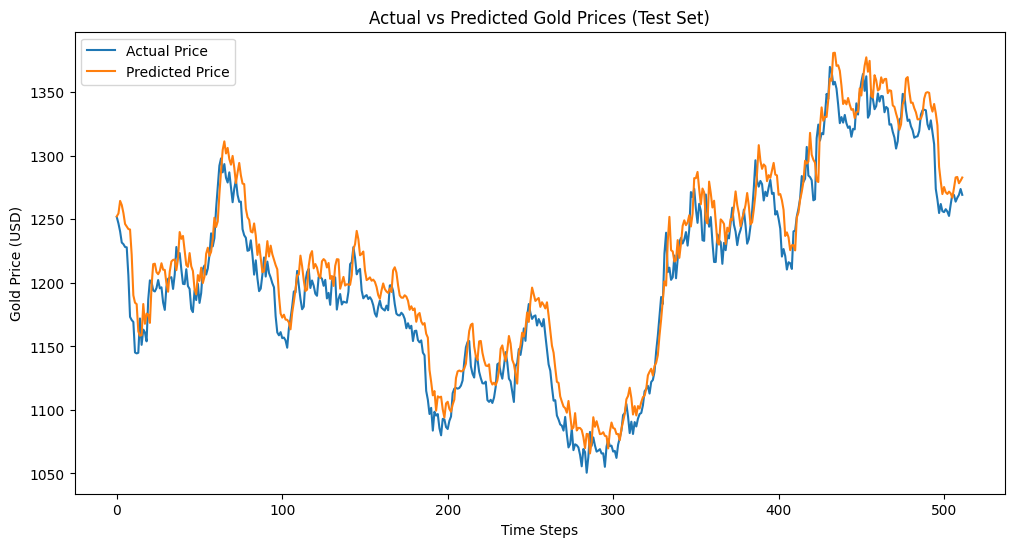

In [10]:
plt.figure(figsize=(12,6))
plt.plot(test_targets_inv, label='Actual Price')
plt.plot(test_samples_inv, label='Predicted Price')
plt.title("Actual vs Predicted Gold Prices (Test Set)")
plt.xlabel("Time Steps")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.show()

##Using recurrent dropout

In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


500/500 ━━━━━━━━━━━━━━━━━━━━ 43s 76ms/step - loss: 0.0436 - val_loss: 0.1406
Epoch 2/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - loss: 0.0330 - val_loss: 0.1686
Epoch 3/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - loss: 0.0314 - val_loss: 0.1387
Epoch 4/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 74ms/step - loss: 0.0306 - val_loss: 0.1576
Epoch 5/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - loss: 0.0302 - val_loss: 0.1427
Epoch 6/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - loss: 0.0307 - val_loss: 0.1718
Epoch 7/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - loss: 0.0298 - val_loss: 0.1636
Epoch 8/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 75ms/step - loss: 0.0311 - val_loss: 0.1451
Epoch 9/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 75ms/step - loss: 0.0296 - val_loss: 0.1475
Epoch 10/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - loss: 0.0306 - val_loss: 0.1381
Epoch 11/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - loss: 0.0297 - val_loss: 0.1380
Epoch 12/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 

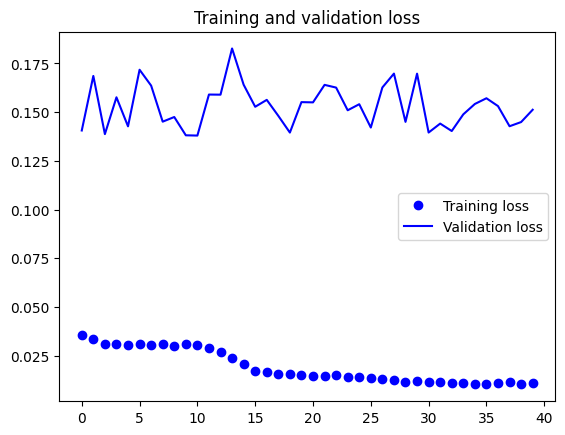

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##Evaluate model on test data and Plot actual vs predicted prices acc.

In [13]:
test_samples = []
test_targets = []

for _ in range(test_steps):
    sample_batch, target_batch = next(test_gen)
    predictions = model.predict(sample_batch)
    test_samples.extend(predictions.flatten())
    test_targets.extend(target_batch)

# Inverse transform to original scale
test_samples_inv = scaler.inverse_transform(np.array(test_samples).reshape(-1, 1)).flatten()
test_targets_inv = scaler.inverse_transform(np.array(test_targets).reshape(-1, 1)).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [14]:
mae = mean_absolute_error(test_targets_inv, test_samples_inv)
mse = mean_squared_error(test_targets_inv, test_samples_inv)
rmse = np.sqrt(mse)
r2 = r2_score(test_targets_inv, test_samples_inv)

print(f"\n📊 Evaluation Metrics:")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")


📊 Evaluation Metrics:
MAE:  182.65
MSE:  33857.36
RMSE: 184.00
R²:   -4.5602


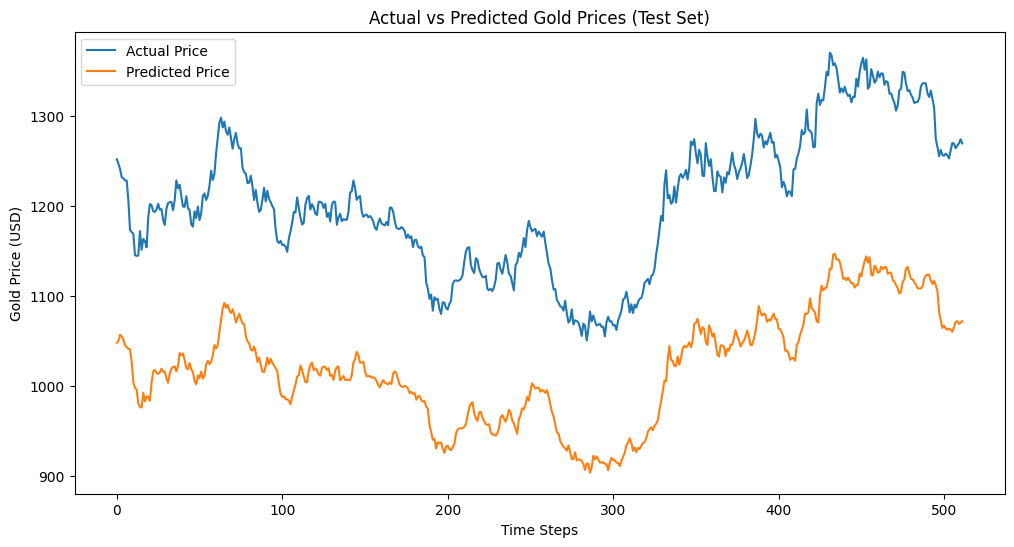

In [15]:
plt.figure(figsize=(12,6))
plt.plot(test_targets_inv, label='Actual Price')
plt.plot(test_samples_inv, label='Predicted Price')
plt.title("Actual vs Predicted Gold Prices (Test Set)")
plt.xlabel("Time Steps")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.show()